# Comparison of Parallax Measurement from Various Sources 

I want a table that compares some parallax measurements, predicted or real, from Spitzer, Terrestrial parallax, Kepler, and NGRST.

In [4]:
import numpy as np

# for displaying images from url
import urllib.request
from io import BytesIO 
from PIL import Image
from IPython.display import display

# for plotting
import matplotlib.pyplot as plt

# time
from astropy.time import Time

In [5]:
def delta_beta_delta_tau(piEN, piEE, qn, qe, sqn, sqe):
    '''
    Inputs
    -------
    piEN, piEE:     (:math:`\pi_{\rm{E},N}, \, \pi_{\rm{E},E}`) give scale to 
                    the q values.

    qn, qe:         are the projected position of Earth in the lens plane, 
                    relative to :math:`t_p`

    sqn, sqe:       are the projected satellite position in the lens plane,
                    relative to earth

    Notes
    ------
    ..math::
        \pi_{rel} = \rm{au}(\frac{1}{D_L}-\frac{1}{D_S})$
    ..math::
        \pi_{rel} = \pi_E\theta_E
    '''

    delta_tau = piEN*(qn+sqn) + piEE(qe+sqe)
    delta_beta = -piEE*(qn+sqn) + piEN(qe+sqe)

    return delta_beta, delta_tau


In [6]:
def print_table_row(piEN, piEE, sdb, sdt, kdb, kdt, rdb, rdt, tvs, tvk, tvr):
    '''
    Printing the parallax comparison data for easy copying into a markdown table.

    Inputs
    -------
    piEN:           Einstein parallax in the celestial North direction
    piEE:           Einstein parallax in the celestial East direction
    sdb:            Spitzer :math:`\Delta\beta`
    sdt:            Spitzer :math:`\Delta\tau`
    kdb:            Kepler :math:`\Delta\beta`
    kdt:            Kepler :math:`\Delta\tau`
    rdb:            NGRST :math:`\Delta\beta`
    rdt:            NGRST :math:`\Delta\tau`
    tvs:            terrestrial vs Spitzer
                    time to achieve the same |:math:`\Delta\beta,\,\Delta\tau`|
    tvk:            terrestrial vs Kepler
                    time to achieve the same |:math:`\Delta\beta,\,\Delta\tau`|
    tvr:            terrestrial vs NGRST
                    time to achieve the same |:math:`\Delta\beta,\,\Delta\tau`|
    '''

    pi = '| (%1.2f, %1.2f) |' %(piEN, piEE)
    spitzer = ' (%1.2f, %1.2f) |' %(sdb, sdt)
    kepler = ' (%1.2f, %1.2f) |' %(kdb, kdt)
    roman = ' (%1.2f, %1.2f) |' %(rdb, rdt)
    terrestrial = ' (%1.2f, %1.2f, %1.2f) |' %(tvs, tvk, tvr)

    row = pi + spitzer + kepler + roman + terrestrial

    print(row)


In [7]:
def get_vernal_peri(self, year):

	years = list(range(2005,2021))
	perihelion = [3372.540499087, 3740.165261868, 4104.332037400, 4468.498813419, 4836.123576385, 5199.498764492, \
					5565.290377501, 5931.540278206, 6294.707154200, 6661.998616987, 7026.790330067, 7390.457156155, \
					7758.081919031, 8121.748744610, 8486.707107861, 8853.831920967]
	vernal = [3450.017141061, 3815.262279952, 4180.499085511, 4545.735891070, 4910.983113294, 5276.224779964, \
					5641.467141080, 6006.712279971, 6371.953946642, 6737.200474423, 7102.442141095, 7467.681724434, \
					7832.931029993, 8198.171307778, 8563.409502230, 8928.653946680]

	return vernal[years==year],perihelion[years==year]

In [8]:
def get_parallax_psi(earth_ecc, parallax_phi):

	parallax_psi = parallax_phi

	for i in range(4):
		fun	= parallax_psi - earth_ecc * np.sin(parallax_psi)
		dif	= parallax_phi - fun
		der	= 1.0 - earth_ecc * np.cos(parallax_psi)
		parallax_psi += dif / der

	return parallax_psi

In [9]:
def calculate_q(ra, dec, year, t, t_p):
	'''
	Calcualate position of Earth projected onto the lens plane, relative to 
	Earth's position at :math:`t_p`.

	Inputs
	-------
	ra:         right ascention of the event.
	dec:        declination of the event.
	year:       int.
	t:          time relative to :math:`t_p`.
	t_p:        time close to :math:`t_0`.

	Returns
	--------
	Returns the projected position of the Sun in the lens frame.

	q_n, q_e:   N & E components of Earth velocity projected onto lens plane 
				(v_Earth_perp) in AU/day units
				
	Notes
	------
	The mathematical description is given in Gould, A., 2004, ApJ, 606, 319.
	sun = Earth - Sun cartesian vector in heliocentric frame in units of AU.
	S_n, S_e: N & E components of sun vector projected onto lens plane in AU units. 
	The projected Sun position in the lens frame in AU, Delta(s_n, s_e).

	'''

	right_ascension = right_ascension
	declination = declination
	vernal, peri = get_vernal_peri(year)
	earth_ecc = 0.0167

	north = np.array([0.0, 0.0, 1.0])
	spring = np.array([1.0, 0.0 ,0.0])		
	summer = np.array([0.0, 0.9174, 0.3971]) 

	parallax_offset = vernal - peri

	parallax_rad = np.array([np.cos(right_ascension) * np.cos(declination), \
								np.sin(right_ascension) * np.cos(declination), \
								np.sin(declination)])

	# East direction on lens plane
	parallax_east = np.cross(north,parallax_rad)
	parallax_east /= np.linalg.norm(parallax_east)

	# North direction on lens plane
	parallax_north = np.cross(parallax_rad,parallax_east)

	# Perihelion phase
	parallax_phi = (1.0-parallax_offset/365.25)*2.0*np.pi
	parallax_psi= get_parallax_psi(parallax_phi)

	costh = (np.cos(parallax_psi) - earth_ecc) / ( 1.0 - earth_ecc*np.cos(parallax_psi) )
	sinth = -np.sqrt(1.0-costh*costh)

	# Earth position at perihelion?
	parallax_xpos = spring*costh + summer*sinth
	parallax_ypos = -spring*sinth + summer*costh

	# Galactic rotation
	galaxy_rotation_ra = 5.550227
	galaxy_rotation_dec = 0.8435095
	galaxy_rotation_direction  = np.array([np.cos(galaxy_rotation_ra) * np.cos(galaxy_rotation_dec), \
									np.sin(galaxy_rotation_ra) * np.cos(galaxy_rotation_dec), \
									np.sin(galaxy_rotation_dec)])
	galaxy_rotation_east = np.dot(galaxy_rotation_direction,parallax_east)
	galaxy_rotation_north = np.dot(galaxy_rotation_direction,parallax_north)
	galaxy_north_ra = 3.157
	galaxy_north_dec = 0.473 
	galaxy_north_direction  = np.array([np.cos(galaxy_north_ra) * np.cos(galaxy_north_dec), \
									np.sin(galaxy_north_ra) * np.cos(galaxy_north_dec), \
									np.sin(galaxy_north_dec)])
	solar_pecular_velocity_kms = 12.24 * galaxy_rotation_direction + 7.25 * galaxy_north_direction
	solar_pecular_velocity_east = np.dot(solar_pecular_velocity_kms, parallax_east)
	solar_pecular_velocity_north = np.dot(solar_pecular_velocity_kms, parallax_north)
	solar_pecular_velocity_kms = np.array([solar_pecular_velocity_north,solar_pecular_velocity_east])

	sun = np.zeros([3], np.float64)
	S_e_arr	= np.zeros([3], np.float64)
	S_n_arr	= np.zeros([3], np.float64)
						
	# Calculates the eccentric anomaly
	int_adjust	= np.array([0.0, -1.0, 1.0])

	for j in range(2, -1, -1):
		parallax_phi = ( (t_peak + int_adjust[j] - peri) / 365.25 ) * 2.0*np.pi
		parallax_psi = get_parallax_psi(parallax_phi)

		for i in range(3):
			sun[i] = parallax_xpos[i] * (np.cos(parallax_psi)-earth_ecc) + \
						parallax_ypos[i] * np.sin(parallax_psi) * \
							np.sqrt(1.0-earth_ecc*earth_ecc)
			S_n_arr[j] += sun[i] * parallax_north[i]
			S_e_arr[j] += sun[i] * parallax_east[i]

	vn0	= (S_n_arr[2] - S_n_arr[1]) / 2.0
	ve0	= (S_e_arr[2] - S_e_arr[1]) / 2.0

	v_Earth_perp = np.array([-vn0, -ve0])

	sun = np.zeros(([3, len(ts_in)]), np.float64)

	# Calculate S_n and S_e for the actual time value
	parallax_phi = ( (ts_in - peri) / 365.25 ) * (2.0*np.pi)
	parallax_psi = get_parallax_psi(parallax_phi)
	q_n = -S_n_arr[0] - vn0 * (ts_in - t_peak)
	q_e = -S_e_arr[0] - ve0 * (ts_in - t_peak)

	for i in range(3):
		sun[i,:] = parallax_xpos[i] * ( np.cos(parallax_psi) - earth_ecc ) + \
						parallax_ypos[i] * np.sin(parallax_psi) * \
							np.sqrt( 1-earth_ecc*earth_ecc)
		q_n += sun[i,:]*parallax_north[i]
		q_e += sun[i,:]*parallax_east[i]

	return q_n, q_e

In [10]:
def calculate_sq(t, t_p, position, ra, dec):
  '''
  Calcualate satellite position projected onto the lens plane, relative to Earth

  Inputs
  -------
  t:          time relative to :math:`t_p`.
  t_p:        time close to :math:`t_0`.
  position:   satellite position data.
  ra:         right ascention of the event.
  dec:        declination of the event.
  '''

  north = np.array([0.0, 0.0, 1.0])
  parallax_rad = np.array([np.cos(ra) * np.cos(dec), \
                              np.sin(ra) * np.cos(dec), \
                              np.sin(dec)])

  parallax_east = np.cross(north, parallax_rad)
  parallax_east /= np.linalg.norm(parallax_east)
  parallax_north = np.cross(parallax_rad, parallax_east)

  spitzer_ra = np.interp(t, position[:,0], position[:,1])
  spitzer_dec = np.interp(t, position[:,0], position[:,2])
  spitzer_distance = np.interp(t, position[:,0], position[:,3])

  sun = np.zeros(([3, len(t)]), np.float64)
  sun[0,:] = -np.cos(spitzer_ra)*np.cos(spitzer_dec)
  sun[1,:] = -np.sin(spitzer_ra)*np.cos(spitzer_dec)
  sun[2,:] = -np.sin(spitzer_dec)

  s_n = np.zeros_like(t)
  s_e = np.zeros_like(t)

  for i in range(3):
    s_n += sun[i,:]*parallax_north[i]*spitzer_distance
    s_e += sun[i,:]*parallax_east[i]*spitzer_distance

    return sq_n, sq_e

In [11]:
def compute_spitzer_perpendicular_distance(ra, dec, t, lens_distance, spitzer_pos):

	spitzer_ra = np.interp(t, spitzer_pos[:,0], spitzer_pos[:,1])
	spitzer_dec = np.interp(t, spitzer_pos[:,0], spitzer_pos[:,2])
	spitzer_distance = np.interp(t, spitzer_pos[:,0], spitzer_pos[:,3])

	# ra, dec to n, e, r
	spitzer_direction = np.zeros(3, np.float64)
	spitzer_direction[0] = np.cos(spitzer_ra)*np.cos(spitzer_dec)
	spitzer_direction[1] = np.sin(spitzer_ra)*np.cos(spitzer_dec)
	spitzer_direction[2] = np.sin(spitzer_dec)

	parallax_rad = np.array([np.cos(ra) * np.cos(dec), \
								np.sin(ra) * np.cos(dec), \
								np.sin(dec)])

	print('spitzer_distance:', spitzer_distance)
	print('spitzer_direction:', spitzer_direction)
	print('spitzer_norm:', np.linalg.norm(spitzer_direction, axis=0))
	print('lens_distance:', lens_distance)
	print('lens_direction:', parallax_rad)
	print('lens_norm:', np.linalg.norm(parallax_rad, axis=0))
	print('angle:', np.arccos(np.dot(spitzer_direction, parallax_rad)))

	s1 = 0.0
	s2 = 0.0
	for k in range(3):
		s1 += lens_distance*spitzer_direction[k]*parallax_rad[k] - \
            spitzer_distance*spitzer_direction[k]**2
		s2 += lens_distance*parallax_rad[k]**2 - \
            spitzer_distance*parallax_rad[k]*spitzer_direction[k]

		print(k, spitzer_direction[k], parallax_rad[k]) 

	print('s1:', s1)
	print('s2:', s2)

	ab_ratio = -s1/s2
	print('ab_ratio:', ab_ratio)

	v = ab_ratio*parallax_rad + spitzer_direction

	print(ab_ratio*parallax_rad)
	print(spitzer_direction)
	print('v:', v)
	print('norm v:', np.linalg.norm(v, axis=0))

	v /= np.linalg.norm(v, axis=0)

	print('v:', v)

	A = np.array([[v[0], spitzer_distance*spitzer_direction[0]-lens_distance*parallax_rad[0]],[v[1], spitzer_distance*spitzer_direction[1]-lens_distance*parallax_rad[1]]])
	c = spitzer_distance*spitzer_direction[:2]

	x = np.linalg.solve(A,c)
	print('x:', x)

	d_perp = x[0]

	check = x[0]*v[2] - spitzer_distance*spitzer_direction[2] - x[1]*(lens_distance*parallax_rad[2] - spitzer_distance*spitzer_direction[2])

	return d_perp, check

## Earth's Orbit

In polar coordinates:
$$r = \frac{\mathcal{l}}{1+e\cos{\theta}},$$
where $\mathcal{l}=b^2/a$, and $e=\sqrt{1-b^2/a^2}$ ($b=\sqrt{a^2(1-e^2)}$).

The orbital parameters are:
$$a = 149.60\times10^6\,\rm{km}$$
$$\,\,\,\, = 1.0000010178\,\rm{AU}$$
$$b = 0.99972314503\,\rm{AU}$$
$$e = 0.0167$$
$$T = 365.256\,\rm{days}$$

Conversion to cartesian coordinates:
$$x = r\cos{\theta},$$
$$y = r\sin{\theta}.$$
$\theta=360/P\,[degrees]$, where $P$ is the sidereel orbital period (not sure if that is correct, but it is what I have done).

To incline the orbital plane:
$$X(\theta,i) = x(\theta).\cos{i},$$
$$Y(\theta,i) = y(\theta),$$
$$Z(\theta,i) = x(\theta).\sin{i}$$
where $i$ is the inclination of the orbital plane.


In [12]:
def XYZ(x,y,i):
    ''' '''

    Z = y*np.sin(i)
    Y = y*np.cos(i)

    return x, Y, Z

In [13]:
def cartesian(r,theta):
    ''' '''

    x = r*np.cos(theta)
    y = r*np.sin(theta)

    return x, y

In [14]:
def polar_ellipse(a, e, theta):
    ''' '''

    b2 = a**2*(1-e**2)
    l = b2/a
    print(l)
    r = l / (1 + e*np.cos(theta))

    return r

In [15]:
def calc_theta(t, P):
    ''' '''
    
    w = 2*np.pi/P  # rad per day
    theta = w*t

    return theta

In [16]:
def parallax_rad_calc(ra, dec):
	'''Event pointing (ra, dec) to (x, y, z) unit vector. '''
	north = np.array([0.0, 0.0, 1.0])
	parallax_rad = np.array([np.cos(ra) * np.cos(dec), \
								np.sin(ra) * np.cos(dec), \
								np.sin(dec)])

	return parallax_rad

In [17]:
def d_perp_calc(lens_distance, satellite_direction, satellite_distance, parallax_rad):
	''' '''

	print('satellite_distance:', satellite_distance)
	print('satellite_direction:', satellite_direction)
	print('lens_distance:', lens_distance)
	print('lens_direction:', parallax_rad)
	print('lens_norm:', np.linalg.norm(parallax_rad,axis=0))
	print('angle:', np.arccos(np.dot(satellite_direction,parallax_rad)))

	s1 = 0.0
	s2 = 0.0
	for k in range(3):
		s1 += lens_distance*satellite_direction[k]*parallax_rad[k] - satellite_distance*satellite_direction[k]**2
		s2 += lens_distance*parallax_rad[k]**2 - satellite_distance*parallax_rad[k]*satellite_direction[k]

		print(k, satellite_direction[k], parallax_rad[k]) 

	print('s1:', s1)
	print('s2:', s2)

	ab_ratio = -s1/s2
	print('ab_ratio:', ab_ratio)

	v = ab_ratio*parallax_rad + satellite_direction

	print(ab_ratio*parallax_rad)
	print(satellite_direction)
	print('v:', v)
	print('norm v:', np.linalg.norm(v,axis=0))

	v /= np.linalg.norm(v,axis=0)

	print('v:', v)

	A = np.array([[v[0], satellite_distance*satellite_direction[0]-lens_distance*parallax_rad[0]],[v[1], satellite_distance*satellite_direction[1]-lens_distance*parallax_rad[1]]])
	c = satellite_distance*satellite_direction[:2]

	x = np.linalg.solve(A,c)
	print('x:', x)

	d_perp = x[0]

	return d_perp

0.9997221275161458
Heliocentric Earth position


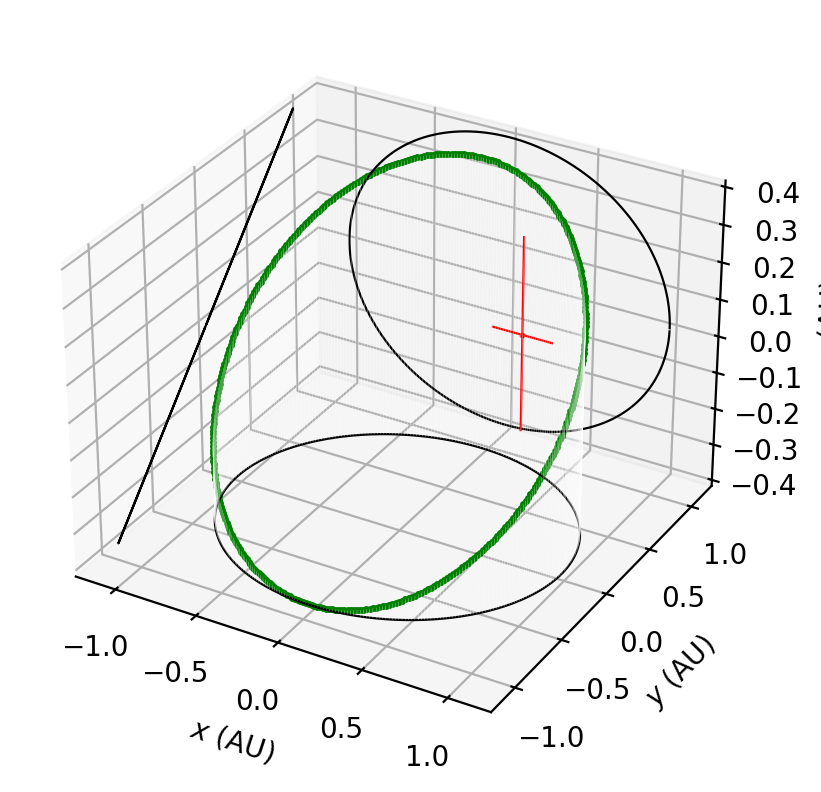

In [18]:
P = 365.256  # days

# Apoapsis on ~July 4th
# Vernal equinox on Sep 22nd
# 80 days
theta_offset = 80/P*np.pi

a = 1.0000010178  # AU
e = 0.0167
i = 23.5*np.pi/180  # rad. Guessing

days = np.arange(365)  # days of the year

theta = calc_theta(days, P)
r = polar_ellipse(a, e, theta)

#plt.plot(theta, r)

x, y = cartesian(r,theta)

#plt.plot(x, y)

X, Y, Z = XYZ(x,y,i)

print('Heliocentric Earth position')  # must be heliocentric, right?

fig, ax = plt.subplots(subplot_kw=dict(projection='3d'), dpi=200)

# plot the spitzer direction
markerline, stemlines, baseline = ax.stem(X, Y, Z, linefmt='w-', \
    markerfmt='g.', basefmt='k-', bottom=-0.4)
# the last point is too far from it's neighbour and it looks silly on the plot

stemlines.set_linewidth(0.1) 
markerline.set_markersize(3)
baseline.set_markersize(0.1) 
baseline.set_linewidth(0.1)

# Create a projection onto the XY plane
ax.plot(X, Y, zs=-0.4, \
        zdir='z', label='curve in (x, y)', color='k', lw=0.8)
# Create a projection onto the YZ plane
ax.plot(Y, Z, zs=-1.2, \
        zdir='x', label='curve in (y, z)', color='k', lw=0.8)
# Create a projection onto the XZ plane
ax.plot(X, Z, zs=1.2, \
        zdir='y', label='curve in (x, z)', color='k', lw=0.8)

# GC xyz
# Galactic center direction on a 1.4 au square
x =  0.08808053415511066
dx = 0.18444591973731086
y =  1.4 
dy = 0.33217429856297964
z =  -0.1301820000760379
dz = 0.2708555048457165
ax.plot([x-dx,x+dx], [z, z], zs=1.2, \
        zdir='y', color='r', lw=0.8)
ax.plot([x,x], [z-dz, z+dz], zs=1.2, \
        zdir='y', color='r', lw=0.8)
ax.plot([x], [z], zs=1.2, \
        zdir='y', label='bulge', color='r', ms=1.4, marker='x')

# Adjusting the limits
ax.set_zlim(-0.4, 0.4)
ax.set_xlim(-1.2, 1.2)
ax.set_ylim(-1.2, 1.2)

ax.set(xlabel=r'$x$ (AU)', ylabel=r'$y$ (AU)', zlabel=r'$z$ (AU)')

plt.show()


## 2016 Spitzer Events

In [19]:
6830/365

18.71232876712329

In [20]:
spitzer_position_file = 'fort23.2016.spitzer.txt'

spitzer_pos = np.loadtxt(spitzer_position_file)
spitzer_pos[:,0] += 6830.0 
spitzer_pos[:,1] = np.unwrap(np.deg2rad(spitzer_pos[:,1]))
spitzer_pos[:,2] = np.deg2rad(spitzer_pos[:,2])

spitzer_ra = spitzer_pos[:,1]
spitzer_dec = spitzer_pos[:,2]
spitzer_distance = spitzer_pos[:,3]

# (ra, dec) to (x, y, z) unit vector?
spitzer_direction = np.zeros((spitzer_pos.shape[0], 3), np.float64)
spitzer_direction[:,0] = np.cos(spitzer_ra)*np.cos(spitzer_dec)
spitzer_direction[:,1] = np.sin(spitzer_ra)*np.cos(spitzer_dec)
spitzer_direction[:,2] = np.sin(spitzer_dec)

heliocentric spitzer position
[7389.50833333 7468.09791667 7560.09791667 7574.09166667 7654.09791667
 7744.09791667]


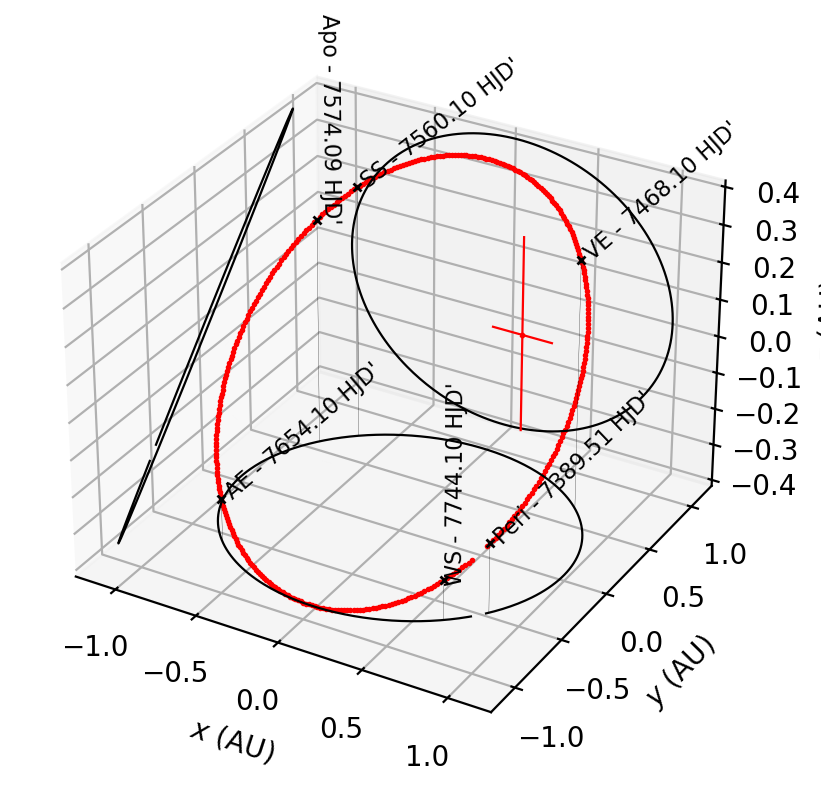

In [21]:
print('heliocentric spitzer position')  # must be heliocentric, right?

fig, ax = plt.subplots(subplot_kw=dict(projection='3d'), dpi=200)

# plot the spitzer direction
markerline, stemlines, baseline = ax.stem(spitzer_direction[:-1, 0], \
    spitzer_direction[:-1, 1], spitzer_direction[:-1, 2], linefmt='w-', \
        markerfmt='ro', basefmt='k-', bottom=0.0)
# the last point is too far from it's neighbour and it looks silly on the plot

stemlines.set_linewidth(0.0001)  # So you can't see them
markerline.set_markersize(1)
baseline.set_markersize(0.0001)  # So you can't see them
baseline.set_linewidth(0.0001)  # So you can't see it

# Create a projection onto the XY plane
ax.plot(spitzer_direction[:-1, 0], spitzer_direction[:-1, 1], zs=-0.4, \
        zdir='z', label='curve in (x, y)', color='k', lw=0.8)
# Create a projection onto the YZ plane
ax.plot(spitzer_direction[:-1, 1], spitzer_direction[:-1, 2], zs=-1.2, \
        zdir='x', label='curve in (x, y)', color='k', lw=0.8)
# Create a projection onto the XZ plane
ax.plot(spitzer_direction[:-1, 0], spitzer_direction[:-1, 2], zs=1.2, \
        zdir='y', label='curve in (x, y)', color='k', lw=0.8)

# Annotate date near solstices and equinoxes
times = ['2016-01-02T00:12:00.0', '2016-03-20T14:21:00.0', \
        '2016-06-20T14:21:00.0', '2016-07-04T14:12:00.0', \
        '2016-09-22T14:21:00.0', '2016-12-21T14:21:00.0']
t = Time(times, format='isot', scale='utc')
t = t.jd 
t = t-2450000.0
st = spitzer_pos[:,0]
print(t)

x = []
y = []
z = []
for tt in t:
    tt = round(tt,0)
    x.append(spitzer_direction[st==tt,0][0])
    y.append(spitzer_direction[st==tt,1][0])
    z.append(spitzer_direction[st==tt,2][0])

# Periapsis - seems to line up with y=0
label = 'Peri - %1.2f HJD\'' %(t[0])
ax.text(x[0], y[0], z[0], label, zdir='y', fontsize=8)
# Vernal equinox: Sun, 20 Mar 2016, 5:30 am
label = 'VE - %1.2f HJD\'' %(t[1])
ax.text(x[1], y[1], z[1], label, zdir='y', fontsize=8)
# Summer solstice: Tue, 20 Jun 2016, 10:34 pm 
label = 'SS - %1.2f HJD\'' %(t[2])
ax.text(x[2], y[2], z[2], label, zdir='y', fontsize=8)
# Apoapsis: July 4th
label = 'Apo - %1.2f HJD\'' %(t[3])
ax.text(x[3], y[3], z[3], label, zdir='z', fontsize=8)
# Autumnal equinox: Fri, 22 Sep 2016, 2:21 pm
label = 'AE - %1.2f HJD\'' %(t[4])
ax.text(x[4], y[4], z[4], label, zdir='y', fontsize=8)
# winter solstice: Wed, 21 Dec 2016, 11:44 am
label = 'WS - %1.2f HJD\'' %(t[5])
ax.text(x[5], y[5], z[5], label, zdir='z', fontsize=8)

# plot the spitzer direction
markerline, stemlines, baseline = ax.stem(x, y, z, linefmt='k-', \
    markerfmt='kx', basefmt='k-', bottom=-0.4)
# the last point is too far from it's neighbour and it looks silly on the plot

stemlines.set_linewidth(0.1)  # So you can't see them
markerline.set_markersize(3)
baseline.set_markersize(0.0001)  # So you can't see them
baseline.set_linewidth(0.0001)  # So you can't see it

# GC xyz
# Galactic center direction on a 1.4 au square
x =  0.08808053415511066
dx = 0.18444591973731086
y =  1.4 
dy = 0.33217429856297964
z =  -0.1301820000760379
dz = 0.2708555048457165
ax.plot([x-dx,x+dx], [z, z], zs=1.2, \
        zdir='y', color='r', lw=0.8)
ax.plot([x,x], [z-dz, z+dz], zs=1.2, \
        zdir='y', color='r', lw=0.8)
ax.plot([x], [z], zs=1.2, \
        zdir='y', label='bulge', color='r', ms=1.4, marker='x')

# Adjusting the limits
ax.set_zlim(-0.4, 0.4)
ax.set_xlim(-1.2, 1.2)
ax.set_ylim(-1.2, 1.2)

ax.set(xlabel=r'$x$ (AU)', ylabel=r'$y$ (AU)', zlabel=r'$z$ (AU)')

plt.show()

Spitzer's coordinates are $x>0$ and $y=0$ when Earth is at perihelion.

## Bulge Direction
RA = 17h 45.6m, Dec = -28⁰ 56' (2000.0)

<style>
    table {
        font-size: 16px; /* Adjust the font size as needed */
    }
</style>
|           |      RA      |      Dec     |      RA (deg)     |      Dec (deg)    |
|:---------:|:------------:|:------------:|:-----------------:|:-----------------:|
| KMT min | 17:22:46.56 | -21:33:22.36 |  260.694     | -21.556211  |
| KMT max | 18:19:32.69 | -36:25:10.45 |  274.886208  | -36.419569  |
| GC      | 17:45.6:0   | -28:56:0     |  266.4       | -28.933333  |
|         |      |      | $266.4^{+8.5}_{-5.8}$ | $-28.9^{+7.4}_{-7.5}$ |

In [22]:
import pandas as pd
import numpy as np

df = pd.read_csv('KMT2022events.txt', sep='\s+')
RA = df.ra
Dec = df.dec
RAmin = np.nanmin(RA)
RAmax = np.nanmax(RA)
Decmin = np.nanmin(Dec)
Decmax = np.nanmax(Dec)
print(RAmin, Decmin)
print(RAmax, Decmax)

def stringhr2decimaldeg(RA):
    hr, min, s = RA.split(':')
    hr = float(hr)
    min = float(min)
    s = float(s)
    degrees = 360*hr/24 + 360*min/(24*60) + 360*s/(24*60*60)
    return degrees

def stringdeg2decimaldeg(Dec):
    deg, arcmin, arcsec = Dec.split(':')
    deg = float(deg)
    arcmin = float(arcmin)
    arcsec = float(arcsec)
    if deg>=0:
        degrees = deg + arcmin/60 + arcsec/(60*60)
    elif deg<0:
        degrees = deg - arcmin/60 - arcsec/(60*60)
    return degrees

RAmindeg = stringhr2decimaldeg(RAmin)
print(RAmindeg)
RAmaxdeg = stringhr2decimaldeg(RAmax)
print(RAmaxdeg)
Decmindeg = stringdeg2decimaldeg(Decmin)
print(Decmindeg)
Decmaxdeg = stringdeg2decimaldeg(Decmax)
print(Decmaxdeg)

RAGC = '17:45.6:0'
DecGC = '-28:56:0'

RAGCdeg = stringhr2decimaldeg(RAGC)
print(RAGCdeg)
DecGCdeg = stringdeg2decimaldeg(DecGC)
print(DecGCdeg)


print(36.4-28.9)

17:22:46.56 -21:33:22.36
18:19:32.69 -36:25:10.45
260.694
274.88620833333334
-21.55621111111111
-36.41956944444444
266.4
-28.933333333333334
7.5


In [23]:
# GC xyz

GCra = 266.4
dGCra = 7.5
GCdec = -28.9
dGCdec = 7.5
D = 1.2  # au

#x=r^2sinϕcosθ, y=r^2sinsinθ, z=rcosϕ

def spherical2cartesian(ra, dec, d=1.0, shape='sphere', GC=False):
    ra = np.deg2rad(ra)
    #dra = np.deg2rad(dra)
    dec = np.deg2rad(dec)
    #ddec = np.deg2rad(ddec)
    x = d * np.cos(dec) * np.cos(ra)
    y = d * np.cos(dec) * np.sin(ra)
    z = d * np.sin(dec)

    if shape=='square':
        # the errors with this aren't exactly right
        scaled_coord = np.array([d, d, d])
        coord = np.array([x, y, z])
        for i in coord:
            keep = True
            scale = d/np.abs(i)
            hold = scale*coord
            for j in hold:
                if (j>d) or (j<-d):
                    keep= False
            if keep:
                scaled_coord = hold.copy()
                scale_used = scale*1.

    if shape=='sphere':
        scale_used = 1.0
        scaled_coord = np.array([x, y, z])

    #dx = np.sqrt((d**2*np.cos(dec)*np.cos(ra)*ddec)**2 \
    #             + (d**2*np.sin(dec)*np.sin(ra)*dra)**2) * scale_used
    #dy = np.sqrt((d**2*np.cos(dec)*np.sin(ra)*ddec)**2 \
    #             + (d**2*np.sin(dec)*np.cos(ra)*dra)**2) * scale_used
    #dz = np.sqrt((d*np.sin(ra)*dra)**2) * scale_used

    x, y, z = scaled_coord

    if GC:
        print('Galactic center direction on a %3.1f au %s' %(d, shape))
        
    print('x = ', x)
    print('y = ', y)
    print('z = ', z)

    return x, y, z

xGC, yGC, zGC = spherical2cartesian(GCra, GCdec, D, shape='square', GC=True)

# Testing

print()
D = 1.4
x = D * np.cos(np.deg2rad(GCdec)) * np.cos(np.deg2rad(GCra))
y = D * np.cos(np.deg2rad(GCdec)) * np.sin(np.deg2rad(GCra))
z = D * np.sin(np.deg2rad(GCdec))
print('x = ', x)
print('y = ', y)
print('z = ', z)
print(np.sqrt(x**2+y**2+z**2))

xGC, yGC, zGC = spherical2cartesian(GCra, GCdec, D, shape='sphere', GC=True)

print()
print('dec check:     (-28.9 deg)')
print(np.rad2deg(np.sin(z/D)))


print('ra check:      (93.6 deg from y+; 3.6 deg from x-)')
print(np.rad2deg(np.sin(x/D)))
#print(360-266.4)




Galactic center direction on a 1.2 au square
x =  -0.07549760070438055
y =  -1.2
z =  -0.6637453391674724

x =  -0.07695922147174289
y =  -1.223231796831565
z =  -0.6765953365570031
1.4
Galactic center direction on a 1.4 au sphere
x =  -0.07695922147174289
y =  -1.223231796831565
z =  -0.6765953365570031

dec check:     (-28.9 deg)
-26.62466921086073
ra check:      (93.6 deg from y+; 3.6 deg from x-)
-3.1480129875240808


In [24]:
GCra = np.array([266.4, 266.4-7.5, 266.4, 266.4, 266.4+7.5])
GCdec = np.array([-28.9-7.5, -28.9, -28.9, -28.9+7.5, -28.9])
xGC, yGC, zGC = spherical2cartesian(GCra, GCdec, shape='sphere', GC=True)
print(xGC, yGC, zGC)

Galactic center direction on a 1.0 au sphere
x =  [-0.0505397  -0.16854615 -0.05497087 -0.05846148  0.05954497]
y =  [-0.80330552 -0.85908692 -0.873737   -0.92921859 -0.8734372 ]
z =  [-0.59341889 -0.48328238 -0.48328238 -0.36487678 -0.48328238]
[-0.0505397  -0.16854615 -0.05497087 -0.05846148  0.05954497] [-0.80330552 -0.85908692 -0.873737   -0.92921859 -0.8734372 ] [-0.59341889 -0.48328238 -0.48328238 -0.36487678 -0.48328238]


## Spitzer Season

In [25]:

# Event locations
events = {}
events['labels'] = ['ra string', 'ra decimal degrees', 'dec string', 'dec decimal degrees'\
                    'lens_distance',  'x', 'y', 'z', 't_0', 't_1', 't_n']
events['OB161195'] = ['17:55:23.5', 0, '−30:12:26.1', 0, 3.9, 0, 0, 0, 7568.7693, 7571.5, 7594.0]
events['OB161093'] = ['17:56:01.03', 0, '−32:42:48.5', 0, 8.1, 0, 0, 0, 7560.318, 7556, 7597]
events['OB161067'] = ['18:12:49.08', 0, '−27:00:45.5', 0, 3.7, 0, 0, 0, 7564.3, 7562.5, 7579.5]
events['OB161045'] = ['17:36:51.19', 0, '−34:32:39.7', 0, 5.0, 0, 0, 0, 7559.201, 7557.9, 7577.6]
events['OB161266'] = ['17:51:24.86', 0, '−29:44:32.1', 0, 3.1, 0, 0, 0, 7583.5, 7586, 7593]
events['OB161190'] = ['17:58:52.30', 0, '−27:36:48.8', 0, 7.0, 0, 0, 0, 7582.16, 7578, 7596]
events['OB160168'] = ['17:50:49.89', 0, '-31:45:30.1', 0, 1.6, 0, 0, 0, 7492.4, 7557.93, 7584.48]
#events[''] = [, 0, , 0, 0, 0, ]

In [26]:
tmin = []
tmax = []
for event in events:
    hold = events[event]
    if event == 'labels':
        index_tmin = hold.index('t_1') + 1
        index_tmax = hold.index('t_n') + 1
    else:
        tmin.append(hold[index_tmin])
        tmax.append(hold[index_tmax])

smin = min(tmin)
smax = max(tmax)
srange = smax-smin

print('Spitzer season:', smin, '<t<', smax, ' (range:', srange, 'days)') 
print('Spitzer season: 7557<t<7596 (range:', 7596-7557, 'days)')

Spitzer season: 7556 <t< 7597  (range: 41 days)
Spitzer season: 7557<t<7596 (range: 39 days)


### Earth and Spitzer positions

In [27]:
# Position files
webb_pos = pd.read_csv('horizons_result_WEBB_slim.csv')  # 2023
earth23_pos = pd.read_csv('horizons_results_Earth2023_slim.csv')  # 2023
spitzer_pos = pd.read_csv('horizons_results_Spitzer2016_slim.csv')  # 2016
earth16_pos = pd.read_csv('horizons_results_Earth2016_slim.csv')  # 2016

# Unpacking
X_webb = np.array(webb_pos[' X'])
Y_webb = np.array(webb_pos[' Y'])
Z_webb = np.array(webb_pos[' Z'])
T_webb = np.array(webb_pos['JDTDB'])

X_earth23 = np.array(earth23_pos[' X'])
Y_earth23 = np.array(earth23_pos[' Y'])
Z_earth23 = np.array(earth23_pos[' Z'])
T_earth23 = np.array(earth23_pos['JDTDB'])

X_spitzer = np.array(spitzer_pos[' X'])
Y_spitzer = np.array(spitzer_pos[' Y'])
Z_spitzer = np.array(spitzer_pos[' Z'])
T_spitzer = np.array(spitzer_pos['JDTDB'])

X_earth16 = np.array(earth16_pos[' X'])
Y_earth16 = np.array(earth16_pos[' Y'])
Z_earth16 = np.array(earth16_pos[' Z'])
T_earth16 = np.array(earth16_pos['JDTDB'])

# Spitzer season: 7557<t<7596
season_start = 7557
season_end = 7596

X_spitzerS = X_spitzer[(T_spitzer>season_start)&(T_spitzer<season_end)]
Y_spitzerS = Y_spitzer[(T_spitzer>season_start)&(T_spitzer<season_end)]
Z_spitzerS = Z_spitzer[(T_spitzer>season_start)&(T_spitzer<season_end)]
T_spitzerS = T_spitzer[(T_spitzer>season_start)&(T_spitzer<season_end)]

X_earth16S = X_earth16[(T_earth16>season_start)&(T_earth16<season_end)]
Y_earth16S = Y_earth16[(T_earth16>season_start)&(T_earth16<season_end)]
Z_earth16S = Z_earth16[(T_earth16>season_start)&(T_earth16<season_end)]
T_earth16S = T_earth16[(T_earth16>season_start)&(T_earth16<season_end)]

FileNotFoundError: [Errno 2] No such file or directory: 'horizons_result_WEBB_slim.csv'

In [ ]:
xGC, yGC, zGC = spherical2cartesian(GCra, GCdec, shape='sphere', GC=True)

### Perpendicular distance
observer1 position: $$o_1=(x_{o1},y_{o1},z_{o1})$$
observer2 position: $$o_1=(x_{o2},y_{o2},z_{o2})$$
event direction: $$\mathbf{n}={x_n,y_n,z_n}$$
parametric observer2-event line: 
$$x=x_{o2}+x_nt,\,\,\,\,\,\,y=y_{o2}+y_nt,\,\,\,\,\,\,z=z_{o2}+z_nt.$$
plane equation (perp. to event from observer1): 
$$x_n(x-x_{o1})+y_n(y-y_{o1})+z_n(z-z_{o1})=0$$
line-of-signt distance from observer1 to observer2 ($D_{||}$):
$$x_n((x_{o2}+x_nD_{||})-x_{o1})+y_n((y_{o2}+y_nD_{||})-y_{o1})+z_n((z_{o2}+z_nD_{||})-z_{o1})=0$$
$$x_nx_{o2}+x_n^2D_{||}-x_nx_{o1}+y_ny_{o2}+y_n^2D_{||}-y_ny_{o1}+z_nz_{o2}+z_n^2D_{||}-z_nz_{o1}=0$$
$$x_n^2D_{||}+y_n^2D_{||}+z_n^2D_{||}=x_nx_{o1}-x_nx_{o2}+y_ny_{o1}-y_ny_{o2}+z_nz_{o1}-z_nz_{o2}$$
$$D_{||}=\frac{x_nx_{o1}-x_nx_{o2}+y_ny_{o1}-y_ny_{o2}+z_nz_{o1}-z_nz_{o2}}{x_n^2+y_n^2+z_n^2}$$
$$D_{||}=\frac{x_n(x_{o1}-x_{o2})+y_n(y_{o1}-y_{o2})+z_n(z_{o1}-z_{o2})}{x_n^2+y_n^2+z_n^2}$$
vector joining observer line-of-sights on o1 perp. plane:
$$\mathbf{D}=(x_{o2}+x_nD_{||}-x_{o1}, y_{o2}+y_nD_{||}-y_{o1}, z_{o2}+z_nD_{||}-z_{o1})$$
perpendicular distance between o1 and o2
$$D_\perp=\sqrt{(x_{o2}+x_nD_{||}-x_{o1})^2+(y_{o2}+y_nD_{||}-y_{o1})^2+(z_{o2}+z_nD_{||}-z_{o1})^2}$$

In [42]:
def calculate_t(direction, observer1, observer2):

    # Unpacking
    xn, yn, zn = direction  # line-of-sight to event/GC (normal to perp plane)
    xo1, yo1, zo1 = observer1  # observer 1 position
    xo2, yo2, zo2 = observer2  # observer 2 position

    t_numerator = xn*(xo1-xo2)+yn*(yo1-yo2)+zn*(zo1-zo2)
    t_denominator = xn**2+yn**2+zn**2

    t = t_numerator/t_denominator

    return t

def planar_distances(direction, observer1, observer2):

    # Unpacking
    xn, yn, zn = direction  # line-of-sight to event/GC (normal to perp plane)
    xo1, yo1, zo1 = observer1  # observer 1 position
    xo2, yo2, zo2 = observer2  # observer 2 position

    # parallel distance
    D_parallel = calculate_t(direction, observer1, observer2)  # positive means further away from event

    D = np.array([xo2+xn*D_parallel-xo1, yo2+yn*D_parallel-yo1, zo2+zn*D_parallel-zo1])
    D_perp = np.linalg.norm(D)

    return D_perp, D_parallel, D

# Testing
n = [0.0, 0.0, 1.0]  # bulge in z dir
o1 = [-3.0, -4.0, 0.0]
o2 = [0.0, -4.0, 0.0]
dpp, dpl, d = planar_distances(n, o1, o2)
print(dpp, dpl, d)

n = [0.0, 0.0, 1.0]  # bulge in z dir
o1 = [-3.0, -4.0, 0.0]
o2 = [0.0, -4.0, -5]
dpp, dpl, d = planar_distances(n, o1, o2)
print(dpp, dpl, d)

n = [0.0, -1.0, 0.0]  # bulge in y- dir
o1 = [-3.0, -4.0, 0.0]
o2 = [0.0, -2.0, -4.0]
dpp, dpl, d = planar_distances(n, o1, o2)
print(dpp, dpl, d)

n = [0.0, -1.0, 0.0]  # bulge in y- dir
o1 = [-3.0, -4.0, 0.0]
o2 = [-4.0, 3.0, 0.0]
dpp, dpl, d = planar_distances(n, o1, o2)
print(dpp, dpl, d)

n = [0.0, 1.0, 0.0]  # bulge in y dir
o1 = [-3.0, -4.0, 0.0]
o2 = [-4.0, 3.0, 0.0]
dpp, dpl, d = planar_distances(n, o1, o2)
print(dpp, dpl, d)

#3.0 0.0 [3. 0. 0.]
#3.0 5.0 [3. 0. 0.]
#5.0 2.0 [ 3.  0. -4.]
#1.0 7.0 [-1.  0.  0.]
#1.0 -7.0 [-1.  0.  0.]

3.0 0.0 [3. 0. 0.]
3.0 5.0 [3. 0. 0.]
5.0 2.0 [ 3.  0. -4.]
1.0 7.0 [-1.  0.  0.]
1.0 -7.0 [-1.  0.  0.]


In [61]:
def calculate_t(direction, observer1, observer2):

    # Unpacking
    xn, yn, zn = direction  # line-of-sight to event/GC (normal to perp plane)
    xo1, yo1, zo1 = observer1  # observer 1 position
    xo2, yo2, zo2 = observer2  # observer 2 position

    t_numerator = xn*(xo1-xo2)+yn*(yo1-yo2)+zn*(zo1-zo2)
    t_denominator = xn**2+yn**2+zn**2

    t = t_numerator/t_denominator

    return t

def planar_distances(direction, observer1, observer2):

    # Unpacking
    xn, yn, zn = direction  # line-of-sight to event/GC (normal to perp plane)
    xo1, yo1, zo1 = observer1  # observer 1 position
    xo2, yo2, zo2 = observer2  # observer 2 position

    # parallel distance
    D_parallel = calculate_t(direction, observer1, observer2)  # positive means further away from event

    D_x, D_y, D_z = xo2+xn*D_parallel-xo1, yo2+yn*D_parallel-yo1, zo2+zn*D_parallel-zo1
    D = np.array([D_x, D_y, D_z])
    D_perp = np.sqrt(D_x*D_x + D_y*D_y + D_z*D_z)

    return D_perp, D_parallel, D

nx = np.array([0.0, 0.0, 0.0, 0.0])
ny = np.array([0.0, 0.0, -1.0, -1.0])
nz = np.array([1.0, 1.0, 0.0, 0.0])
n = [nx, ny, nz]
o1x = np.array([-3.0, -3.0, -3.0, -3.0])
o1y = np.array([-4.0, -4.0, -4.0, -4.0])
o1z = np.array([0.0, 0.0, 0.0, 0.0])
o1 = [o1x, o1y, o1z]
o2x = np.array([0.0, 0.0, 0.0, -4.0])
o2y = np.array([-4.0, -4.0, -2.0, 3.0])
o2z = np.array([0.0, -5.0, -4.0, 0.0])
o2 = [o2x, o2y, o2z]

dpp, dpl, d = planar_distances(n, o1, o2)
print(dpp, dpl)
print(d)
#3.0 0.0 [3. 0. 0.]
#3.0 5.0 [3. 0. 0.]
#5.0 2.0 [ 3.  0. -4.]
#1.0 7.0 [-1.  0.  0.]

x = np.array([-0.0505397  -0.16854615 -0.05497087 -0.05846148  0.05954497])  #GC
y = np.array([-0.80330552 -0.85908692 -0.873737   -0.92921859 -0.8734372 ])
z = np.array([-0.59341889 -0.48328238 -0.48328238 -0.36487678 -0.48328238])

nGC = [x, y, z]



[3. 3. 5. 1.] [0. 5. 2. 7.]
[[ 3.  3.  3. -1.]
 [ 0.  0.  0.  0.]
 [ 0.  0. -4.  0.]]


In [2]:
GCx = np.array([-0.0505397 , -0.16854615, -0.05497087, -0.05846148,  0.05954497])  #GC
GCy = np.array([-0.80330552, -0.85908692, -0.873737,   -0.92921859, -0.8734372 ])
GCz = np.array([-0.59341889, -0.48328238, -0.48328238, -0.36487678, -0.48328238])

for i in range(5):
    print(i)

NameError: name 'np' is not defined

### OB161195
Lowest mass-ratio planet. Possibly around a brown dwarf. Systematics.

https://ui.adsabs.harvard.edu/abs/2017ApJ...840L...3S/abstract

<style>
    table {
        font-size: 12px; /* Adjust the font size as needed */
    }
</style>

|        |  $c--$  |  $c-+$	 |  $c+-$  |  $c++$  |  $w--$  |  $w-+$  |  $w+-$  |  $w++$  |
|:------:|:-------:|:-------:|:-------:|:-------:|:-------:|:-------:|:-------:|:-------:|
| ${\pi }_{{\rm{E}},{\rm{N}}}$ | $-0.2154\pm0.0065$ | $0.2335\pm0.0080$ | $-0.3017\pm0.0071$ | $0.1487\pm0.0074$ | $-0.2158\pm0.0066$ | $0.2350\pm0.0080$ | $-0.3016\pm0.0074$ | $0.1491\pm0.0075$ |
| ${\pi }_{{\rm{E}},{\rm{E}}}$ | $-0.380\pm0.032$	| $-0.411\pm0.032$ | $-0.376\pm0.032$ | $-0.404\pm0.031$ | $-0.382\pm0.032$ | $-0.413\pm0.031$ | $-0.377\pm0.032$ | $-0.404\pm0.032$ |

Spitzer Date: 7571.5 - 7594.0 HJD'

$t_0$ = 7568.769 HJD'

(R.A., decl.) = (17:55:23.5, −30:12:26.1) J2000.0

$D_{\rm L}$ = 3.91 kpc

In [3]:
piEN = np.array([-0.2154, 0.2335, -0.3017, 0.1487, -0.2158, 0.2350, -0.3016, 0.1491])
piEE = np.array([-0.380, -0.411, -0.376, -0.404, -0.382, -0.413, -0.377, -0.404])

piE = np.sqrt(piEN**2+piEE**2)

print(piE)

[0.43680334 0.47269784 0.48207768 0.43049703 0.43874097 0.47517786
 0.48279557 0.43063536]


### OB161093
A Sub-Jupiter-mass planet. Systematics.

https://ui.adsabs.harvard.edu/abs/2022AJ....163..254S/abstract

<style>
    table {
        font-size: 12px; /* Adjust the font size as needed */
    }
</style>

|                              |       $u_0<0$      |       $u_0>0$	     |
|:----------------------------:|:------------------:|:------------------:|
| ${\pi }_{{\rm{E}},{\rm{N}}}$ |  $-0.104\pm0.102$  |  $-0.131\pm0.097$  |
| ${\pi }_{{\rm{E}},{\rm{E}}}$ |   $0.256\pm0.147$  |   $0.271\pm0.149$  |

Spitzer Date: 7556 - 7597 HJD'

$t_0$ = 7560.318 HJD'

(α, δ) = (17:56:01.03, −32:42:48.5)

$D_{\rm L}$ = 8.1 kpc

In [6]:
piEN = np.array([-0.104, -0.131])
piEE = np.array([0.256, 0.271])

piE = np.sqrt(piEN**2+piEE**2)

print(piE)

[0.27631866 0.30100166]


### OB161067
No caustic crossing. Planet and M-dwarf

https://ui.adsabs.harvard.edu/abs/2019AJ....157..121C/abstract

<style>
    table {
        font-size: 12px; /* Adjust the font size as needed */
    }
</style>

|          |  $w--$  |  $w++$  |  $w-+$  |  $w+-$  |  $c--$  |  $c++$  |  $c-+$  |  $c+-$  |
|:--------:|:-------:|:-------:|:-------:|:-------:|:-------:|:-------:|:-------:|:-------:|
| ${\pi }_{{\rm{E}},{\rm{N}}}$ | ${0.220}_{-0.014}^{+0.015}$ | $-{0.223}_{-0.015}^{+0.014}$ | ${0.620}_{-0.048}^{+0.052}$ | $-{0.635}_{-0.051}^{+0.048}$ | ${0.196}_{-0.016}^{+0.016}$ | $-{0.198}_{-0.017}^{+0.015}$ | ${0.611}_{-0.047}^{+0.050}$ | $-{0.629}_{-0.052}^{+0.048}$ |
| ${\pi }_{{\rm{E}},{\rm{E}}}$ | $-{0.054}_{-0.008}^{+0.006}$ | $-{0.010}_{-0.008}^{+0.007}$ | $-{0.204}_{-0.017}^{+0.015}$ | $-{0.085}_{-0.010}^{+0.009}$ | $-{0.054}_{-0.009}^{+0.008}$ | $-{0.015}_{-0.009}^{+0.008}$ | $-{0.202}_{-0.016}^{+0.015}$ | $-{0.085}_{-0.010}^{+0.010}$ |

Spitzer Date: 7562.5 - 7579.5

$t_0$ = 7564.3

R.A., decl. = 18:12:49.08, −27:00:45.5

$D_{\rm L}$ = 3.7 kpc

In [9]:
piEN = np.array([0.220, -0.223, 0.620, -0.635, 0.196, -0.198, 0.611, -0.629])
piEE = np.array([-0.054, -0.010, -0.204, -0.085, -0.054, -0.015, -0.202, -0.085])

piE = np.sqrt(piEN**2+piEE**2)

print(piE)

[0.22653035 0.2232241  0.65269901 0.64066372 0.20330273 0.19856737
 0.64352545 0.63471726]


### OB161045
Testing cheap space parallax. Probable high-mass brown dwarf. Single lens with finite source effect.

https://ui.adsabs.harvard.edu/abs/2018ApJ...863...23S/abstract

<style>
    table {
        font-size: 16px; /* Adjust the font size as needed */
    }
</style>

|                              |           $u_0<0$           |           $u_0>0$           |
|:----------------------------:|:---------------------------:|:---------------------------:|
| ${\pi }_{{\rm{E}},{\rm{N}}}$ | ${0.098}_{-0.059}^{+0.027}$ | ${0.076}_{-0.058}^{+0.028}$ |
| ${\pi }_{{\rm{E}},{\rm{E}}}$ | ${0.341}_{-0.012}^{+0.012}$ | ${0.344}_{-0.011}^{+0.013}$ |

Spitzer Date: 2016 June 18 (UT 9:56) and ended on July 8 (UT 2:43)

              7557.9 - 7577.6 JD'

$t_0$ = 7559.201 HJD'

RA, Dec = 17:36:51.19, −34:32:39.7

$D_{\rm L}$ = 5.0 kpc


In [10]:
piEN = np.array([0.098, 0.076])
piEE = np.array([0.341, 0.344])

piE = np.sqrt(piEN**2+piEE**2)

print(piE)

[0.35480276 0.35229533]


### OB161266
Brown dwarf binary or planet? The binary lens limits of the Rich argument

https://ui.adsabs.harvard.edu/abs/2018ApJ...858..107A/abstract

Tables are without and with lens orbital motion

#### A (Green)

<style>
    table {
        font-size: 12px; /* Adjust the font size as needed */
    }
</style>

|          |  $++$  |  $++$  |  $+-$  |  $+-$  |  $-+$  |  $-+$  |  $--$  |  $--$  |
|:--------:|:------:|:------:|:------:|:------:|:------:|:------:|:------:|:------:|
| ${\pi }_{{\rm{E}},{\rm{N}}}$ | $-{0.86}_{-0.10}^{+0.09}$ | $-{0.89}_{-0.09}^{+0.10}$ | $-{0.86}_{-0.10}^{+0.10}$ | $-{0.86}_{-0.11}^{+0.11}$ | ${0.88}_{-0.08}^{+0.08}$ | ${0.87}_{-0.08}^{+0.08}$ | ${0.89}_{-0.07}^{+0.07}$ | ${0.88}_{-0.09}^{+0.08}$ |
| ${\pi }_{{\rm{E}},{\rm{E}}}$ | ${0.482}_{-0.018}^{+0.018}$ | ${0.481}_{-0.019}^{+0.017}$ | ${0.481}_{-0.018}^{+0.016}$ | ${0.479}_{-0.019}^{+0.017}$ | ${0.413}_{-0.018}^{+0.016}$ | ${0.413}_{-0.019}^{+0.017}$ | ${0.411}_{-0.017}^{+0.016}$ | ${0.410}_{-0.019}^{+0.018}$ |

#### B (Yellow)

|          |  $++$  |  $++$  |  $+-$  |  $+-$  |  $-+$  |  $-+$  |  $--$  |  $--$  |
|:--------:|:------:|:------:|:------:|:------:|:------:|:------:|:------:|:------:|
| ${\pi }_{{\rm{E}},{\rm{N}}}$ | ${0.160}_{-0.006}^{+0.006}$ | ${0.171}_{-0.007}^{+0.007}$ | $-{1.857}_{-0.014}^{+0.014}$ | $-{1.810}_{-0.019}^{+0.015}$ | ${1.847}_{-0.014}^{+0.014}$ | ${1.805}_{-0.019}^{+0.024}$ | $-{0.164}_{-0.006}^{+0.006}$ | $-{0.176}_{-0.007}^{+0.007}$ |
| ${\pi }_{{\rm{E}},{\rm{E}}}$ | $-{0.043}_{-0.008}^{+0.008}$ | $-{0.053}_{-0.011}^{+0.013}$ | ${0.074}_{-0.024}^{+0.025}$ | ${0.05}_{-0.03}^{+0.03}$ | $-{0.056}_{-0.025}^{+0.026}$ | $-{0.07}_{-0.03}^{+0.03}$ | $-{0.032}_{-0.007}^{+0.008}$ | $-{0.040}_{-0.010}^{+0.011}$ |	


Spitzer Date: 7586 - 7593

$t_0$ = 7583.5

ra, dec = 17:51:24.86, −29:44:32.1

$D_{\rm L}$ = 3.1 kpc

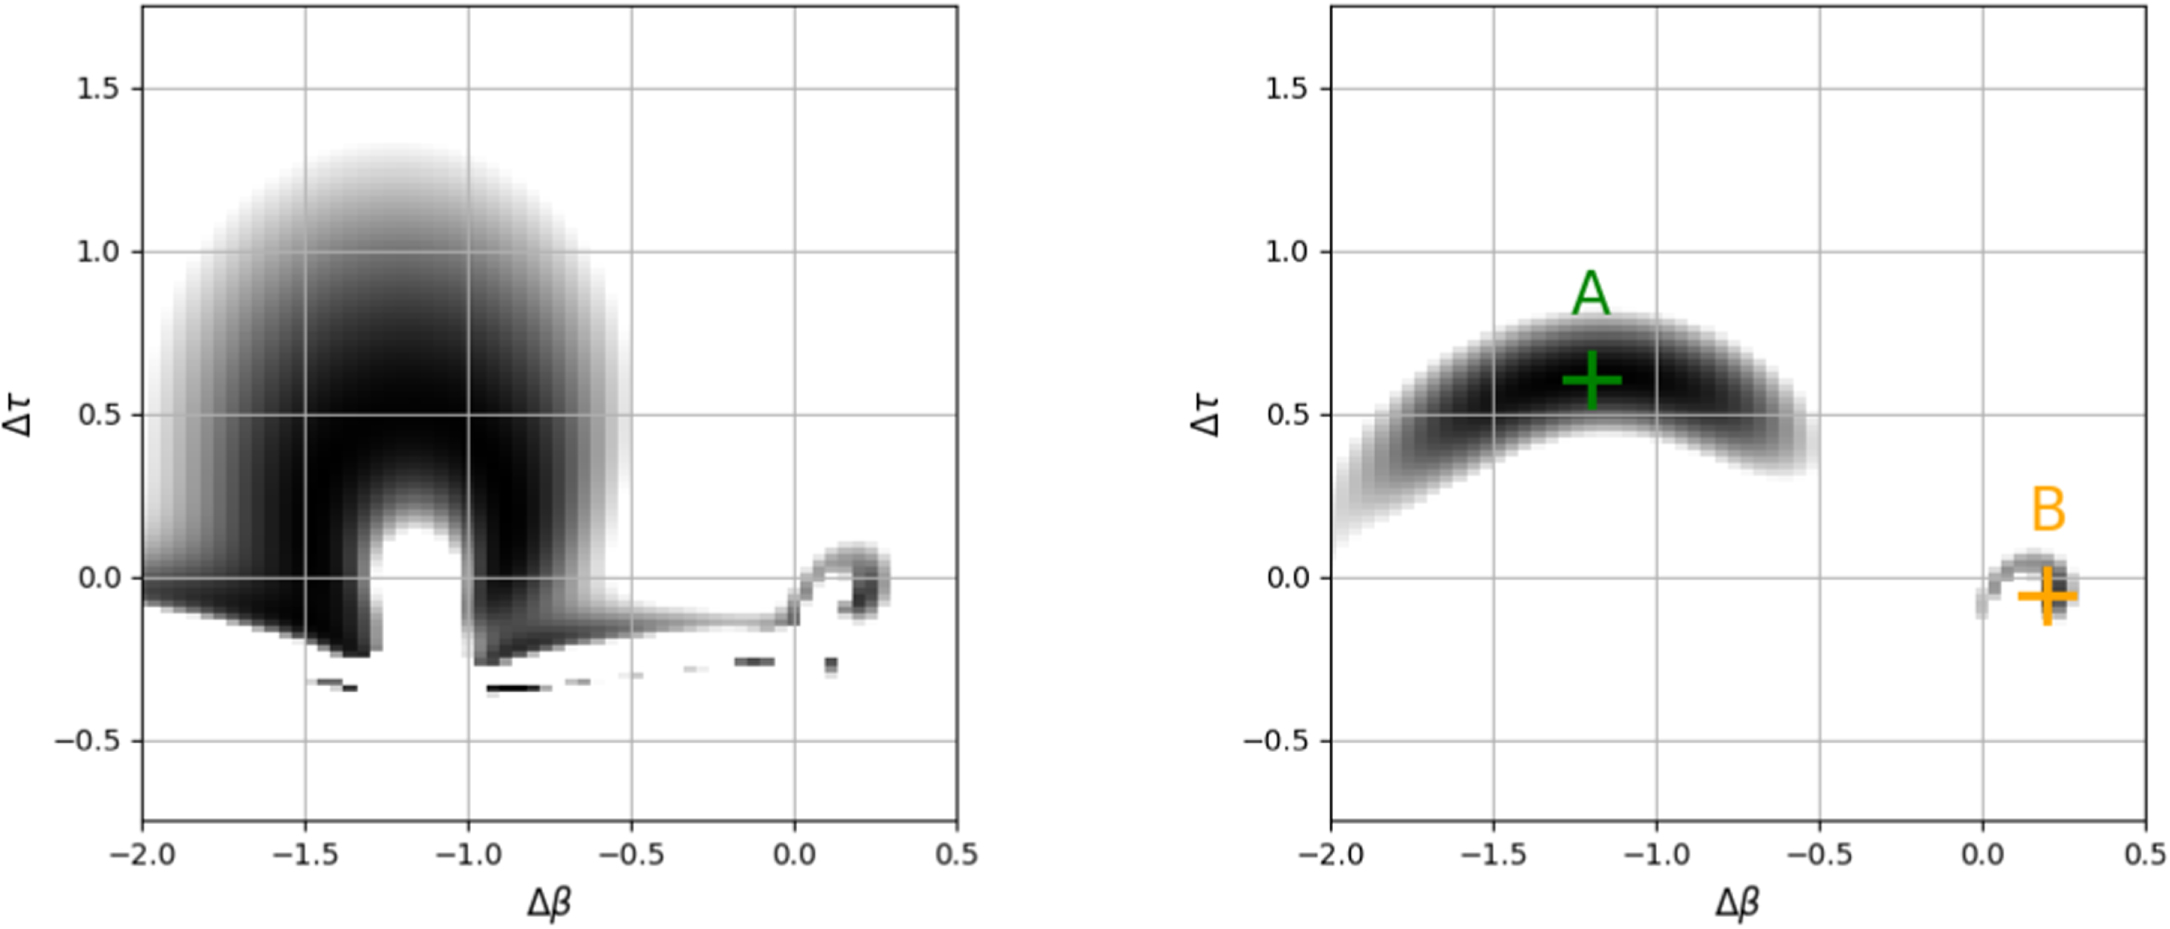

In [14]:
#https://content.cld.iop.org/journals/0004-637X/858/2/107/revision1/apjaabf3ff3_hr.jpg

url = 'https://content.cld.iop.org/journals/0004-637X/858/2/107/revision1/apjaabf3ff3_hr.jpg'
with urllib.request.urlopen(url) as url:
    img = Image.open(BytesIO(url.read()))

display(img)

In [15]:
piEN = np.array([-0.89, -0.86, 0.87, 0.88, 0.171, -1.810, 1.805, -0.176])
piEE = np.array([0.481, 0.479, 0.413, 0.410, -0.053, 0.05, -0.07, -0.040])

piE = np.sqrt(piEN**2+piEE**2)

print(piE)


[1.01166249 0.9843988  0.96305192 0.97082439 0.17902514 1.81069048
 1.80635683 0.18048823]


### OB161190
The First Spitzer Bulge Planet Lies Near the Planet/Brown-dwarf Boundary

https://ui.adsabs.harvard.edu/abs/2018AJ....155...40R/abstract

<style>
    table {
        font-size: 12px; /* Adjust the font size as needed */
    }
</style>

|          |   $-+$   |   $+-$   |   $++$   |   $--$   | 
|:--------:|:--------:|:--------:|:--------:|:--------:|
| ${\pi }_{{\rm{E}},{\rm{N}}}$ | $0.065\pm0.003$ | $-0.063\pm0.002$ | $0.038\pm0.002$ | $-0.037\pm0.002$ |
| ${\pi }_{{\rm{E}},{\rm{E}}}$ | $0.004\pm0.006$ | $0.011\pm0.007$ | $0.008\pm0.006$ | $0.011\pm0.007$ |

Spitzer Date: 7578 - 7596 HJD'

$t_0$ = 7582.16

ra, dec = 17:58:52.30, −27:36:48.8

$D_{\rm L}$ = 7 kpc (actually 6.8 kpc for large parallax solutions and 7.4 kpc for small parallax solutions)


In [16]:
piEN = np.array([0.065, -0.063, 0.038, -0.037])	
piEE = np.array([0.004, 0.011, 0.008, 0.011])

piE = np.sqrt(piEN**2+piEE**2)

print(piE)

[0.06512296 0.06395311 0.03883298 0.03860052]


### MOA-2016-BLG-231
Counter rotating BD binary

https://ui.adsabs.harvard.edu/abs/2019ApJ...871..179C/abstract

<style>
    table {
        font-size: 12px; /* Adjust the font size as needed */
    }
</style>

|                              |         $+-$         |        $--$        | 
|:----------------------------:|:--------------------:|:------------------:|
| ${\pi }_{{\rm{E}},{\rm{N}}}$ | $−0.7598\pm0.3156$   | $−0.4996 ± 0.3047$ |
| ${\pi }_{{\rm{E}},{\rm{E}}}$ | $−0.2283 ± 0.13706$  | $−0.1749 ± 0.1219$ |

Spitzer Date: 7545.5 - 7578.0 HJD'

$t_0$ = 7534.6 HJD'

Ra Dec = 17:53:12.0 -30:11:32.1

$D_{\rm L}$ = 2.9 kpc

In [62]:
piEN = np.array([-0.7598, -0.4996])	
piEE = np.array([-0.2283, -0.1749])

piE = np.sqrt(piEN**2+piEE**2)

print(piE)

[0.79335801 0.52932993]


### OB160168
Binary.



<style>
    table {
        font-size: 12px; /* Adjust the font size as needed */
    }
</style>

|                              |         $u_0<0$         |        $u_0>0$        | 
|:----------------------------:|:-----------------------:|:---------------------:|
| ${\pi }_{{\rm{E}},{\rm{N}}}$ | $0.360\pm0.027$         | $−0.411\pm0.023$      |
| ${\pi }_{{\rm{E}},{\rm{E}}}$ | $0.047\pm0.009$         | $−0.004\pm0.010$      |

Spitzer Date: 7557.93 - 7584.48 HJD'

$t_0$ = 7492.4 HJD'

Ra Dec = 17:50:49.89 -31:45:30.1

$D_{\rm L}$ = 1.6 kpc

In [64]:
piEN = np.array([0.360, -0.411])	
piEE = np.array([0.047, -0.004])

piE = np.sqrt(piEN**2+piEE**2)

print(piE)

[0.36305509 0.41101946]


## Comparison Table

<style>
    table {
        font-size: 12px; /* Adjust the font size as needed */
    }
</style>

| $\pi_{EN},\,\pi_{EE}$ | 2016 Spitzer | K2 C9  | NGRST | $\Delta t$ | 
|:---------------------:|:------------:|:------:|:-----:|:----------:|
